In [ ]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Enable fallback for unsupported operations on certain devices
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

sys.path.append('..')

from dataset import PreprocessedDataset
from models import ViTClassifier
from utils import (
    MetricsCalculator,
    compute_class_weights,
    Trainer,
    WeightedBCELoss,
    FocalLoss,
    AsymmetricLoss,
    CombinedLoss,
    compute_pos_weights,
    EarlyStopping
)
from utils.config_utils import load_config, load_env, get_device, print_config, validate_config
from utils.data_analysis import analyze_dataset
from utils.augmentations import (
    get_train_augmentation, 
    Mixup, 
    CutMix, 
    MixupCutmix,
    create_transforms
)
from utils.sampling import ImbalancedMultiLabelSampler
from utils.schedulers import create_scheduler, CosineAnnealingWarmRestarts
from utils.tta import TTAWrapper, EnsembleTTA

import wandb

SEED = 5252
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
# Load environment variables and advanced config
env_vars = load_env()
config = load_config('../configs/config.yaml')
validate_config(config)

# Create timestamp-based checkpoint directory for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_dir = f"checkpoints/run_{timestamp}"
config['checkpoint']['save_dir'] = checkpoint_dir

# Create the checkpoint directory
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

# Save run info and config to checkpoint directory
run_info = {
    'timestamp': timestamp,
    'run_name': f'vit_ich_improved_{timestamp}',
    'checkpoint_dir': checkpoint_dir,
    'start_time': datetime.now().isoformat(),
    'config': config
}

import yaml
with open(f'{checkpoint_dir}/run_info.yaml', 'w') as f:
    yaml.dump(run_info, f, default_flow_style=False, indent=2)

print(f"Configuration: {config['model']['name']}")
print(f"Checkpoint: {checkpoint_dir}")

print("\nFull Configuration:")
print_config(config)

# Get device
device = get_device(config['hardware']['device'])
print(f"\nUsing device: {device}")

Loaded environment variables from .env
✓ Configuration validated successfully
Configuration: google/vit-base-patch16-224
Checkpoint: checkpoints/run_20251019_231624

Full Configuration:
model:
  name: google/vit-base-patch16-224
  pretrained: True
  num_classes: 5
  input_channels: 9
  channel_adaptation: deep_conv
  dropout: 0.35
  backend: huggingface
  head_type: attention_mlp
  head_hidden_dims: [512, 256, 128]
  head_num_attention_heads: 8
  head_attention_dropout: 0.25
  head_use_residual: True
data:
  data_root: DL_Project_Processed_Data
  train_split: train
  val_split: val
  test_split: test
  batch_size: 16
  num_workers: 0
  pin_memory: False
  sampler:
    type: imbalanced
    strategy: sqrt_inverse_freq
    rare_class_boost: 2.5
    num_samples: None
augmentation:
  mode: standard
  rotation_degrees: 15
  translate: [0.15, 0.15]
  scale_range: [0.85, 1.15]
  horizontal_flip: True
  vertical_flip: False
  intensity_shift: 0.15
  intensity_scale: 0.15
  noise_std: 0.02
  aug

In [3]:
# Create augmentation and datasets with advanced sampling
print("\nLoading datasets...")

# Create transforms using the new create_transforms function
train_transform = create_transforms(config, split='train')
val_transform = create_transforms(config, split='val')

# Create datasets
data_root = config['data']['data_root']

train_dataset = PreprocessedDataset(
    root_dir=os.path.join('..', data_root, 'train'),
    tranform=train_transform
)
val_dataset = PreprocessedDataset(
    root_dir=os.path.join('..', data_root, 'val'),
    tranform=val_transform
)
test_dataset = PreprocessedDataset(
    root_dir=os.path.join('..', data_root, 'test'),
    tranform=val_transform
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Create advanced sampler for imbalanced multi-label classification
sampler_config = config['data']['sampler']
train_sampler = None
shuffle_train = True

if sampler_config['type'] == 'imbalanced':
    train_sampler = ImbalancedMultiLabelSampler(
        dataset=train_dataset,
        strategy=sampler_config['strategy'],
        rare_class_boost=sampler_config['rare_class_boost'],
        num_samples=sampler_config.get('num_samples', None)
    )
    shuffle_train = False
    print(f"Imbalanced sampler: {sampler_config['rare_class_boost']}x boost for rare classes")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=shuffle_train,
    sampler=train_sampler,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory'],
    drop_last=True if train_sampler else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory']
)

print(f"Batch size: {config['data']['batch_size']} | Train batches: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")



Loading datasets...
Train: 1828 | Val: 228 | Test: 229
Imbalanced sampler: 2.5x boost for rare classes
Batch size: 16 | Train batches: 114 | Val: 15 | Test: 15


In [4]:
# Compute class weights for advanced loss functions
print("\nComputing class weights...")

train_labels = []
for _, labels in train_dataset:
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()
    train_labels.append(labels)
train_labels = np.array(train_labels)

# Compute pos weights
strategy = config['loss'].get('pos_weight_strategy', 'sqrt_inverse_freq')
pos_weight = compute_pos_weights(train_labels, strategy=strategy)

# Print class distribution
class_names = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
pos_counts = train_labels.sum(axis=0)
total = len(train_labels)

print(f"Class weights (strategy={strategy}):")
for i, name in enumerate(class_names):
    pos = int(pos_counts[i])
    pos_pct = (pos / total) * 100
    print(f"  {name:20s}: {pos:4d} samples ({pos_pct:5.1f}%) → weight {pos_weight[i]:.3f}")

# Get per-class configurations for advanced loss
per_class_focal_alpha = config['loss'].get('per_class_focal_alpha')
per_class_focal_alpha_tensor = torch.tensor(per_class_focal_alpha, dtype=torch.float32).to(device) if per_class_focal_alpha else None

per_class_gamma_neg = config['loss'].get('per_class_gamma_neg')
per_class_gamma_neg_tensor = torch.tensor(per_class_gamma_neg, dtype=torch.float32).to(device) if per_class_gamma_neg else None

per_class_gamma_pos = config['loss'].get('per_class_gamma_pos')
per_class_gamma_pos_tensor = torch.tensor(per_class_gamma_pos, dtype=torch.float32).to(device) if per_class_gamma_pos else None

# Move to device
pos_weight = pos_weight.to(device)


Computing class weights...
Class weights (strategy=sqrt_inverse_freq):
  epidural            :   90 samples (  4.9%) → weight 4.394
  intraparenchymal    :  447 samples ( 24.5%) → weight 1.758
  intraventricular    :  400 samples ( 21.9%) → weight 1.889
  subarachnoid        :  515 samples ( 28.2%) → weight 1.597
  subdural            :  465 samples ( 25.4%) → weight 1.712


In [5]:
# Create model using factory function
print("\nInitializing model...")
from models.vit_model import create_vit_model

model = create_vit_model(config)
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {config['model']['name']} | Params: {total_params/1e6:.1f}M ({trainable_params/1e6:.1f}M trainable)")
print(f"Head: {config['model'].get('head_type')} | Dropout: {config['model']['dropout']}")


Initializing model...


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: google/vit-base-patch16-224 | Params: 88.2M (88.2M trainable)
Head: attention_mlp | Dropout: 0.35


In [6]:
# Create Advanced Combined Loss
print("\nConfiguring loss and optimizer...")

loss_config = config['loss']
loss_weights = loss_config['loss_weights']

criterion = CombinedLoss(
    loss_weights=loss_weights,
    pos_weight=pos_weight,
    focal_alpha=loss_config['focal_alpha'],
    focal_gamma=loss_config['focal_gamma'],
    per_class_focal_alpha=per_class_focal_alpha_tensor,
    label_smoothing=loss_config['label_smoothing'],
    asymmetric_gamma_neg=loss_config['asymmetric_gamma_neg'],
    asymmetric_gamma_pos=loss_config['asymmetric_gamma_pos'],
    per_class_gamma_neg=per_class_gamma_neg_tensor,
    per_class_gamma_pos=per_class_gamma_pos_tensor,
    class_weights=pos_weight
)

training_config = config['training']

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=float(training_config['learning_rate']),
    weight_decay=float(training_config['weight_decay'])
)

# Create advanced scheduler using factory function
scheduler = create_scheduler(optimizer, config, len(train_loader))

print(f"Loss: {loss_config['type']} (BCE={loss_weights['bce']}, Focal={loss_weights['focal']}, Asym={loss_weights['asymmetric']})")
print(f"Optimizer: AdamW (lr={training_config['learning_rate']}, wd={training_config['weight_decay']})")
print(f"Scheduler: {training_config['scheduler']} (T_0={training_config.get('restart_period', 15)}, warmup={training_config.get('warmup_epochs', 8)})")



Configuring loss and optimizer...
Loss: combined_advanced (BCE=0.4, Focal=0.3, Asym=0.3)
Optimizer: AdamW (lr=0.0003, wd=0.01)
Scheduler: cosine_warm_restarts (T_0=15, warmup=8)


In [7]:
# Initialize W&B
USE_WANDB = True 

if USE_WANDB:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"vit_advanced_{timestamp}"
    
    if env_vars.get('WANDB_API_KEY'):
        wandb.login(key=env_vars['WANDB_API_KEY'])
    
    run = wandb.init(
        project=config['wandb']['project'],
        entity=env_vars.get('WANDB_ENTITY'),
        name=run_name,
        config=config,
        tags=['vit', 'ich', 'multi-label', 'advanced']
    )
    
    if config['wandb']['watch_model']:
        wandb.watch(model, log='all', log_freq=100)
    
    print(f"\nW&B: {wandb.run.name} | {wandb.run.get_url()}")
else:
    print("\nW&B disabled")


wandb: Currently logged in as: noahmv59 (dml_project). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/noahmv/.netrc



W&B: vit_advanced_20251019_231645 | https://wandb.ai/dml_project/Deep%20Machine%20Learning%20Project%20-%20Advanced/runs/yym7v83l


In [8]:
# Create MixupCutmix and Trainer
aug_config = config['augmentation']
mixup_cutmix = MixupCutmix(
    mixup_alpha=aug_config['mixup_alpha'],
    cutmix_alpha=aug_config['cutmix_alpha'],
    num_classes=5,
    prob=aug_config['mixup_cutmix_prob']
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    config=config,
    use_wandb=USE_WANDB,
    mixup_fn=mixup_cutmix,
    cutmix_fn=mixup_cutmix
)

training_config = config['training']
early_stop_config = config['early_stopping']

print(f"\nTraining: {training_config['epochs']} epochs | Early stop: patience={early_stop_config['patience']}")
print(f"Augmentation: Mixup/CutMix prob={aug_config['mixup_cutmix_prob']}")
print(f"Regularization: Dropout={config['model']['dropout']}, Gradient clip={training_config['gradient_clip']}")
print(f"\nStarting training...\n")

trainer.fit(epochs=int(training_config['epochs']))

Backbone frozen for MPS compatibility

Training: 100 epochs | Early stop: patience=20
Augmentation: Mixup/CutMix prob=0.6
Regularization: Dropout=0.35, Gradient clip=1.0

Starting training...


Starting Training for 100 epochs



Epoch 1 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s, loss=0.625]



Epoch 1/100
  Train Loss: 0.4850 | Train AUC: 0.5156 | Train F1: 0.2829
  Val Loss:   0.4890 | Val AUC:   0.3960 | Val F1:   0.2170
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt


Epoch 2 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s, loss=0.607]



Epoch 2/100
  Train Loss: 0.4567 | Train AUC: 0.5772 | Train F1: 0.2871
  Val Loss:   0.4317 | Val AUC:   0.6914 | Val F1:   0.2207
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.2207


Epoch 3 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s, loss=0.651]



Epoch 3/100
  Train Loss: 0.4386 | Train AUC: 0.6740 | Train F1: 0.3749
  Val Loss:   0.4234 | Val AUC:   0.7328 | Val F1:   0.2882
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.2882


Epoch 4 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s, loss=0.522]



Epoch 4/100
  Train Loss: 0.4193 | Train AUC: 0.7373 | Train F1: 0.4488
  Val Loss:   0.4024 | Val AUC:   0.7596 | Val F1:   0.4388
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.4388


Epoch 5 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s, loss=0.555]



Epoch 5/100
  Train Loss: 0.4123 | Train AUC: 0.7666 | Train F1: 0.4846
  Val Loss:   0.4014 | Val AUC:   0.7760 | Val F1:   0.4067
  → No improvement for 1/20 epochs (best: 0.4388 at epoch 4)


Epoch 6 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=0.582]



Epoch 6/100
  Train Loss: 0.3958 | Train AUC: 0.7845 | Train F1: 0.4972
  Val Loss:   0.4285 | Val AUC:   0.7810 | Val F1:   0.3292
  → No improvement for 2/20 epochs (best: 0.4388 at epoch 4)


Epoch 7 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.571]



Epoch 7/100
  Train Loss: 0.4009 | Train AUC: 0.7912 | Train F1: 0.5034
  Val Loss:   0.4110 | Val AUC:   0.7867 | Val F1:   0.3275
  → No improvement for 3/20 epochs (best: 0.4388 at epoch 4)


Epoch 8 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=0.702]



Epoch 8/100
  Train Loss: 0.4045 | Train AUC: 0.7864 | Train F1: 0.4988
  Val Loss:   0.4647 | Val AUC:   0.7928 | Val F1:   0.2826
  → No improvement for 4/20 epochs (best: 0.4388 at epoch 4)


Epoch 9 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s, loss=0.582]



Epoch 9/100
  Train Loss: 0.3958 | Train AUC: 0.7870 | Train F1: 0.5052
  Val Loss:   0.4066 | Val AUC:   0.7899 | Val F1:   0.3600
  → No improvement for 5/20 epochs (best: 0.4388 at epoch 4)


Epoch 10 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, loss=0.491]



Epoch 10/100
  Train Loss: 0.3885 | Train AUC: 0.8243 | Train F1: 0.5499
  Val Loss:   0.3923 | Val AUC:   0.7974 | Val F1:   0.4086
  → No improvement for 6/20 epochs (best: 0.4388 at epoch 4)


Epoch 11 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, loss=0.499]



Epoch 11/100
  Train Loss: 0.3894 | Train AUC: 0.8180 | Train F1: 0.5182
  Val Loss:   0.3927 | Val AUC:   0.7991 | Val F1:   0.4596
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.4596


Epoch 12 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s, loss=0.456]



Epoch 12/100
  Train Loss: 0.3913 | Train AUC: 0.8158 | Train F1: 0.5406
  Val Loss:   0.3915 | Val AUC:   0.7979 | Val F1:   0.4890
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.4890


Epoch 13 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=0.613]



Epoch 13/100
  Train Loss: 0.3929 | Train AUC: 0.8158 | Train F1: 0.5330
  Val Loss:   0.4288 | Val AUC:   0.7977 | Val F1:   0.3021
  → No improvement for 1/20 epochs (best: 0.4890 at epoch 12)


Epoch 14 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, loss=0.437]



Epoch 14/100
  Train Loss: 0.3806 | Train AUC: 0.8341 | Train F1: 0.5585
  Val Loss:   0.3787 | Val AUC:   0.8116 | Val F1:   0.4761
  → No improvement for 2/20 epochs (best: 0.4890 at epoch 12)


Epoch 15 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=0.412]



Epoch 15/100
  Train Loss: 0.3765 | Train AUC: 0.8562 | Train F1: 0.5720
  Val Loss:   0.3719 | Val AUC:   0.8086 | Val F1:   0.5044
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.5044


Epoch 16 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s, loss=0.412]



Epoch 16/100
  Train Loss: 0.3785 | Train AUC: 0.8603 | Train F1: 0.5836
  Val Loss:   0.3638 | Val AUC:   0.8183 | Val F1:   0.4938
  → No improvement for 1/20 epochs (best: 0.5044 at epoch 15)


Epoch 17 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=0.495]



Epoch 17/100
  Train Loss: 0.3734 | Train AUC: 0.8559 | Train F1: 0.5993
  Val Loss:   0.3894 | Val AUC:   0.8166 | Val F1:   0.4068
  → No improvement for 2/20 epochs (best: 0.5044 at epoch 15)


Epoch 18 [Val]: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s, loss=0.42] 



Epoch 18/100
  Train Loss: 0.3583 | Train AUC: 0.8536 | Train F1: 0.5718
  Val Loss:   0.3669 | Val AUC:   0.8150 | Val F1:   0.5050
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.5050


Epoch 19 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s, loss=0.473]



Epoch 19/100
  Train Loss: 0.3666 | Train AUC: 0.8748 | Train F1: 0.6068
  Val Loss:   0.3938 | Val AUC:   0.8148 | Val F1:   0.4683
  → No improvement for 1/20 epochs (best: 0.5050 at epoch 18)


Epoch 20 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=0.439]



Epoch 20/100
  Train Loss: 0.3669 | Train AUC: 0.8754 | Train F1: 0.6039
  Val Loss:   0.3746 | Val AUC:   0.8140 | Val F1:   0.4706
  → No improvement for 2/20 epochs (best: 0.5050 at epoch 18)


Epoch 21 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=0.42] 



Epoch 21/100
  Train Loss: 0.3597 | Train AUC: 0.8882 | Train F1: 0.6297
  Val Loss:   0.3699 | Val AUC:   0.8127 | Val F1:   0.4990
  → No improvement for 3/20 epochs (best: 0.5050 at epoch 18)


Epoch 22 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s, loss=0.428]



Epoch 22/100
  Train Loss: 0.3682 | Train AUC: 0.8534 | Train F1: 0.5874
  Val Loss:   0.3715 | Val AUC:   0.8129 | Val F1:   0.4890
  → No improvement for 4/20 epochs (best: 0.5050 at epoch 18)


Epoch 23 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s, loss=0.537]



Epoch 23/100
  Train Loss: 0.3769 | Train AUC: 0.8494 | Train F1: 0.5829
  Val Loss:   0.4017 | Val AUC:   0.7922 | Val F1:   0.4122
  → No improvement for 5/20 epochs (best: 0.5050 at epoch 18)


Epoch 24 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, loss=0.358]



Epoch 24/100
  Train Loss: 0.3739 | Train AUC: 0.8409 | Train F1: 0.5701
  Val Loss:   0.3648 | Val AUC:   0.8029 | Val F1:   0.5404
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.5404


Epoch 25 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.474]



Epoch 25/100
  Train Loss: 0.3790 | Train AUC: 0.8540 | Train F1: 0.5726
  Val Loss:   0.4079 | Val AUC:   0.8009 | Val F1:   0.4572
  → No improvement for 1/20 epochs (best: 0.5404 at epoch 24)


Epoch 26 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=0.427]



Epoch 26/100
  Train Loss: 0.3769 | Train AUC: 0.8448 | Train F1: 0.5640
  Val Loss:   0.3752 | Val AUC:   0.8101 | Val F1:   0.5266
  → No improvement for 2/20 epochs (best: 0.5404 at epoch 24)


Epoch 27 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, loss=0.498]



Epoch 27/100
  Train Loss: 0.3740 | Train AUC: 0.8507 | Train F1: 0.5789
  Val Loss:   0.3922 | Val AUC:   0.8187 | Val F1:   0.4426
  → No improvement for 3/20 epochs (best: 0.5404 at epoch 24)


Epoch 28 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.44] 



Epoch 28/100
  Train Loss: 0.3785 | Train AUC: 0.8373 | Train F1: 0.5622
  Val Loss:   0.3911 | Val AUC:   0.8174 | Val F1:   0.5029
  → No improvement for 4/20 epochs (best: 0.5404 at epoch 24)


Epoch 29 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, loss=0.425]



Epoch 29/100
  Train Loss: 0.3769 | Train AUC: 0.8509 | Train F1: 0.5783
  Val Loss:   0.3717 | Val AUC:   0.8234 | Val F1:   0.4948
  → No improvement for 5/20 epochs (best: 0.5404 at epoch 24)


Epoch 30 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, loss=0.412]



Epoch 30/100
  Train Loss: 0.3585 | Train AUC: 0.8525 | Train F1: 0.5951
  Val Loss:   0.3698 | Val AUC:   0.8107 | Val F1:   0.4936
  → No improvement for 6/20 epochs (best: 0.5404 at epoch 24)


Epoch 31 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s, loss=0.435]



Epoch 31/100
  Train Loss: 0.3671 | Train AUC: 0.8594 | Train F1: 0.6082
  Val Loss:   0.3829 | Val AUC:   0.8119 | Val F1:   0.4761
  → No improvement for 7/20 epochs (best: 0.5404 at epoch 24)


Epoch 32 [Val]: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s, loss=0.379]



Epoch 32/100
  Train Loss: 0.3661 | Train AUC: 0.8716 | Train F1: 0.6195
  Val Loss:   0.3681 | Val AUC:   0.8208 | Val F1:   0.5256
  → No improvement for 8/20 epochs (best: 0.5404 at epoch 24)


Epoch 33 [Val]: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s, loss=0.411]



Epoch 33/100
  Train Loss: 0.3737 | Train AUC: 0.8579 | Train F1: 0.6197
  Val Loss:   0.3634 | Val AUC:   0.8204 | Val F1:   0.5242
  → No improvement for 9/20 epochs (best: 0.5404 at epoch 24)


Epoch 34 [Val]: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s, loss=0.448]



Epoch 34/100
  Train Loss: 0.3662 | Train AUC: 0.8654 | Train F1: 0.6096
  Val Loss:   0.3801 | Val AUC:   0.8207 | Val F1:   0.5069
  → No improvement for 10/20 epochs (best: 0.5404 at epoch 24)


Epoch 35 [Val]: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s, loss=0.484]



Epoch 35/100
  Train Loss: 0.3693 | Train AUC: 0.8766 | Train F1: 0.6489
  Val Loss:   0.3721 | Val AUC:   0.8259 | Val F1:   0.5129
  → No improvement for 11/20 epochs (best: 0.5404 at epoch 24)


Epoch 36 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s, loss=0.444]



Epoch 36/100
  Train Loss: 0.3643 | Train AUC: 0.8798 | Train F1: 0.6053
  Val Loss:   0.3717 | Val AUC:   0.8191 | Val F1:   0.4745
  → No improvement for 12/20 epochs (best: 0.5404 at epoch 24)


Epoch 37 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, loss=0.451]



Epoch 37/100
  Train Loss: 0.3532 | Train AUC: 0.8711 | Train F1: 0.6130
  Val Loss:   0.3660 | Val AUC:   0.8216 | Val F1:   0.5473
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.5473


Epoch 38 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s, loss=0.404]



Epoch 38/100
  Train Loss: 0.3630 | Train AUC: 0.8733 | Train F1: 0.6337
  Val Loss:   0.3659 | Val AUC:   0.8283 | Val F1:   0.5335
  → No improvement for 1/20 epochs (best: 0.5473 at epoch 37)


Epoch 39 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=0.45] 



Epoch 39/100
  Train Loss: 0.3533 | Train AUC: 0.8923 | Train F1: 0.6566
  Val Loss:   0.3896 | Val AUC:   0.8205 | Val F1:   0.4950
  → No improvement for 2/20 epochs (best: 0.5473 at epoch 37)


Epoch 40 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=0.448]



Epoch 40/100
  Train Loss: 0.3461 | Train AUC: 0.8890 | Train F1: 0.6438
  Val Loss:   0.3739 | Val AUC:   0.8259 | Val F1:   0.5227
  → No improvement for 3/20 epochs (best: 0.5473 at epoch 37)


Epoch 41 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, loss=0.46] 



Epoch 41/100
  Train Loss: 0.3559 | Train AUC: 0.8939 | Train F1: 0.6570
  Val Loss:   0.3711 | Val AUC:   0.8223 | Val F1:   0.5093
  → No improvement for 4/20 epochs (best: 0.5473 at epoch 37)


Epoch 42 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=0.416]



Epoch 42/100
  Train Loss: 0.3542 | Train AUC: 0.8838 | Train F1: 0.6288
  Val Loss:   0.3722 | Val AUC:   0.8215 | Val F1:   0.5185
  → No improvement for 5/20 epochs (best: 0.5473 at epoch 37)


Epoch 43 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.43] 



Epoch 43/100
  Train Loss: 0.3624 | Train AUC: 0.8914 | Train F1: 0.6482
  Val Loss:   0.3659 | Val AUC:   0.8247 | Val F1:   0.5494
  ✓ Best model saved: checkpoints/run_20251019_231624/best_model.pt
  → Validation metric improved to 0.5494


Epoch 44 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s, loss=0.461]



Epoch 44/100
  Train Loss: 0.3569 | Train AUC: 0.8903 | Train F1: 0.6412
  Val Loss:   0.3771 | Val AUC:   0.8275 | Val F1:   0.5370
  → No improvement for 1/20 epochs (best: 0.5494 at epoch 43)


Epoch 45 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s, loss=0.41] 



Epoch 45/100
  Train Loss: 0.3568 | Train AUC: 0.8946 | Train F1: 0.6475
  Val Loss:   0.3662 | Val AUC:   0.8262 | Val F1:   0.5341
  → No improvement for 2/20 epochs (best: 0.5494 at epoch 43)


Epoch 46 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=0.459]



Epoch 46/100
  Train Loss: 0.3483 | Train AUC: 0.8868 | Train F1: 0.6612
  Val Loss:   0.3829 | Val AUC:   0.8280 | Val F1:   0.5159
  → No improvement for 3/20 epochs (best: 0.5494 at epoch 43)


Epoch 47 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.426]



Epoch 47/100
  Train Loss: 0.3529 | Train AUC: 0.9001 | Train F1: 0.6608
  Val Loss:   0.3689 | Val AUC:   0.8306 | Val F1:   0.5355
  → No improvement for 4/20 epochs (best: 0.5494 at epoch 43)


Epoch 48 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=0.48] 



Epoch 48/100
  Train Loss: 0.3485 | Train AUC: 0.9027 | Train F1: 0.6751
  Val Loss:   0.3785 | Val AUC:   0.8271 | Val F1:   0.5348
  → No improvement for 5/20 epochs (best: 0.5494 at epoch 43)


Epoch 49 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s, loss=0.442]



Epoch 49/100
  Train Loss: 0.3418 | Train AUC: 0.9046 | Train F1: 0.6851
  Val Loss:   0.3720 | Val AUC:   0.8285 | Val F1:   0.5368
  → No improvement for 6/20 epochs (best: 0.5494 at epoch 43)


Epoch 50 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, loss=0.436]



Epoch 50/100
  Train Loss: 0.3442 | Train AUC: 0.8924 | Train F1: 0.6699
  Val Loss:   0.3680 | Val AUC:   0.8273 | Val F1:   0.5322
  → No improvement for 7/20 epochs (best: 0.5494 at epoch 43)


Epoch 51 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s, loss=0.439]



Epoch 51/100
  Train Loss: 0.3462 | Train AUC: 0.9000 | Train F1: 0.6587
  Val Loss:   0.3697 | Val AUC:   0.8271 | Val F1:   0.5303
  → No improvement for 8/20 epochs (best: 0.5494 at epoch 43)


Epoch 52 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=0.441]



Epoch 52/100
  Train Loss: 0.3389 | Train AUC: 0.9086 | Train F1: 0.6709
  Val Loss:   0.3704 | Val AUC:   0.8272 | Val F1:   0.5299
  → No improvement for 9/20 epochs (best: 0.5494 at epoch 43)


Epoch 53 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s, loss=0.53] 



Epoch 53/100
  Train Loss: 0.3657 | Train AUC: 0.8834 | Train F1: 0.6410
  Val Loss:   0.3848 | Val AUC:   0.8152 | Val F1:   0.4643
  → No improvement for 10/20 epochs (best: 0.5494 at epoch 43)


Epoch 54 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s, loss=0.444]



Epoch 54/100
  Train Loss: 0.3550 | Train AUC: 0.8790 | Train F1: 0.6266
  Val Loss:   0.3656 | Val AUC:   0.8163 | Val F1:   0.4672
  → No improvement for 11/20 epochs (best: 0.5494 at epoch 43)


Epoch 55 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s, loss=0.493]



Epoch 55/100
  Train Loss: 0.3678 | Train AUC: 0.8771 | Train F1: 0.6096
  Val Loss:   0.3893 | Val AUC:   0.8108 | Val F1:   0.4701
  → No improvement for 12/20 epochs (best: 0.5494 at epoch 43)


Epoch 56 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, loss=0.516]



Epoch 56/100
  Train Loss: 0.3592 | Train AUC: 0.8738 | Train F1: 0.6040
  Val Loss:   0.4401 | Val AUC:   0.8053 | Val F1:   0.4498
  → No improvement for 13/20 epochs (best: 0.5494 at epoch 43)


Epoch 57 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=0.434]



Epoch 57/100
  Train Loss: 0.3708 | Train AUC: 0.8671 | Train F1: 0.6239
  Val Loss:   0.3720 | Val AUC:   0.8110 | Val F1:   0.5397
  → No improvement for 14/20 epochs (best: 0.5494 at epoch 43)


Epoch 58 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s, loss=0.495]



Epoch 58/100
  Train Loss: 0.3505 | Train AUC: 0.8862 | Train F1: 0.6410
  Val Loss:   0.3917 | Val AUC:   0.8114 | Val F1:   0.5102
  → No improvement for 15/20 epochs (best: 0.5494 at epoch 43)


Epoch 59 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s, loss=0.499]



Epoch 59/100
  Train Loss: 0.3579 | Train AUC: 0.8728 | Train F1: 0.6225
  Val Loss:   0.3910 | Val AUC:   0.8054 | Val F1:   0.4681
  → No improvement for 16/20 epochs (best: 0.5494 at epoch 43)


Epoch 60 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, loss=0.518]



Epoch 60/100
  Train Loss: 0.3579 | Train AUC: 0.8943 | Train F1: 0.6553
  Val Loss:   0.3814 | Val AUC:   0.8011 | Val F1:   0.5098
  → No improvement for 17/20 epochs (best: 0.5494 at epoch 43)


Epoch 61 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s, loss=0.616]



Epoch 61/100
  Train Loss: 0.3703 | Train AUC: 0.8779 | Train F1: 0.6294
  Val Loss:   0.4061 | Val AUC:   0.8103 | Val F1:   0.4219
  → No improvement for 18/20 epochs (best: 0.5494 at epoch 43)


Epoch 62 [Val]: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s, loss=0.589]



Epoch 62/100
  Train Loss: 0.3692 | Train AUC: 0.8762 | Train F1: 0.6169
  Val Loss:   0.3952 | Val AUC:   0.8102 | Val F1:   0.4717
  → No improvement for 19/20 epochs (best: 0.5494 at epoch 43)


Epoch 63 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s, loss=0.515]



Epoch 63/100
  Train Loss: 0.3523 | Train AUC: 0.8895 | Train F1: 0.6419
  Val Loss:   0.3760 | Val AUC:   0.8107 | Val F1:   0.5201
  → No improvement for 20/20 epochs (best: 0.5494 at epoch 43)

Early stopping triggered!
Best score: 0.5494 at epoch 43

Restored model to best weights from epoch 43

Stopping early at epoch 63

Training Complete!
Best val_f1_macro: 0.5494



In [12]:
# Optimize Per-Class Thresholds on Validation Set
print("\nOptimizing per-class thresholds on validation set...")

model.eval()
metrics_calc_val = MetricsCalculator(num_classes=5)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        metrics_calc_val.update(logits, labels)

optimal_thresholds = metrics_calc_val.optimize_thresholds(
    method='f1',
    per_class=True,
    num_points=101
)

class_names = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

print("Optimized thresholds (F1-maximizing):")
for i, (name, thr) in enumerate(zip(class_names, optimal_thresholds)):
    print(f"  {name:20s}: {thr:.3f}")

metrics_calc_val.set_thresholds(optimal_thresholds)
optimized_metrics = metrics_calc_val.compute()

print(f"\nValidation with optimized thresholds:")
print(f"  Exact Match: {optimized_metrics.get('accuracy_exact', 0):.3f} | F1: {optimized_metrics.get('f1_macro', 0):.3f} | AUC: {optimized_metrics.get('auc_roc_macro', 0):.3f}")



Optimizing per-class thresholds on validation set...
Optimized thresholds (F1-maximizing):
  epidural            : 0.653
  intraparenchymal    : 0.401
  intraventricular    : 0.635
  subarachnoid        : 0.626
  subdural            : 0.464

Validation with optimized thresholds:
  Exact Match: 0.351 | F1: 0.605 | AUC: 0.821


In [16]:
# Evaluate on Test Set with TTA
print(f"\nEvaluating on test set...")

# Remove W&B hooks to prevent errors during TTA inference
if USE_WANDB:
    import wandb
    # Remove all hooks from the model manually
    if hasattr(model, '_forward_hooks'):
        model._forward_hooks.clear()
    if hasattr(model, '_forward_pre_hooks'):
        model._forward_pre_hooks.clear()
    if hasattr(model, '_backward_hooks'):
        model._backward_hooks.clear()
    # Remove wandb hook names attribute if it exists
    if hasattr(model, '_wandb_hook_names'):
        delattr(model, '_wandb_hook_names')

tta_config = config['evaluation']['tta']
tta_enabled = tta_config['enabled']
tta_strategy = tta_config.get('strategy', 'standard')

if tta_enabled:
    print(f"Using TTA: {tta_strategy} | combine={tta_config.get('combine_method', 'mean')}")
    tta_wrapper = TTAWrapper(model, num_classes=5, device=device)
    metrics_calc_test = MetricsCalculator(num_classes=5, thresholds=optimal_thresholds)
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        probs = tta_wrapper.predict_with_tta(
            images,
            augmentations=tta_strategy,
            combine=tta_config.get('combine_method', 'mean')
        )
        logits = torch.logit(probs.clamp(1e-7, 1 - 1e-7))
        metrics_calc_test.update(logits, labels)
else:
    metrics_calc_test = MetricsCalculator(num_classes=5, thresholds=optimal_thresholds)
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            metrics_calc_test.update(logits, labels)

# Compute final metrics
test_metrics = metrics_calc_test.compute()

print(f"\nTest Results (5 hemorrhage types with optimized thresholds):")
print(f"  Overall: Exact Match={test_metrics['accuracy_exact']:.3f} | F1={test_metrics['f1_macro']:.3f} | AUC={test_metrics['auc_roc_macro']:.3f}")
print(f"\n  Per-class performance:")
for i, name in enumerate(class_names):
    prec = test_metrics.get(f'precision_{name}', 0)
    rec = test_metrics.get(f'recall_{name}', 0)
    f1 = test_metrics.get(f'f1_{name}', 0)
    auc = test_metrics.get(f'auc_roc_{name}', 0)
    thr = optimal_thresholds[i]
    status = " (no predictions)" if f1 == 0 else ""
    print(f"    {name:20s}: P={prec:.3f} R={rec:.3f} F1={f1:.3f} AUC={auc:.3f} | thr={thr:.3f}{status}")

print(f"\nNote: We train on 5 hemorrhage types. 'Healthy' (all 0s) and 'Multiple' (>1 type)")
print(f"      are derived classes for evaluation only, not directly trained.")

# Save results
results = {
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'optimal_thresholds': optimal_thresholds.tolist(),
    'config': config,
    'checkpoint_dir': checkpoint_dir,
    'timestamp': timestamp,
    'tta_enabled': tta_enabled,
    'tta_strategy': tta_strategy if tta_enabled else None
}

results_path = f'{checkpoint_dir}/test_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved results to: {results_path}")



Evaluating on test set...
Using TTA: standard | combine=mean

Test Results (5 hemorrhage types with optimized thresholds):
  Overall: Exact Match=0.345 | F1=0.468 | AUC=0.790

  Per-class performance:
    epidural            : P=0.000 R=0.000 F1=0.000 AUC=0.709 | thr=0.653 (no predictions)
    intraparenchymal    : P=0.536 R=0.726 F1=0.616 AUC=0.831 | thr=0.401
    intraventricular    : P=0.711 R=0.653 F1=0.681 AUC=0.920 | thr=0.635
    subarachnoid        : P=0.417 R=0.717 F1=0.528 AUC=0.737 | thr=0.626
    subdural            : P=0.424 R=0.661 F1=0.517 AUC=0.753 | thr=0.464

Note: We train on 5 hemorrhage types. 'Healthy' (all 0s) and 'Multiple' (>1 type)
      are derived classes for evaluation only, not directly trained.

Saved results to: checkpoints/run_20251019_231624/test_results.json



Generating confusion matrices...
Saved confusion matrices to: checkpoints/run_20251019_231624/confusion_matrices.png


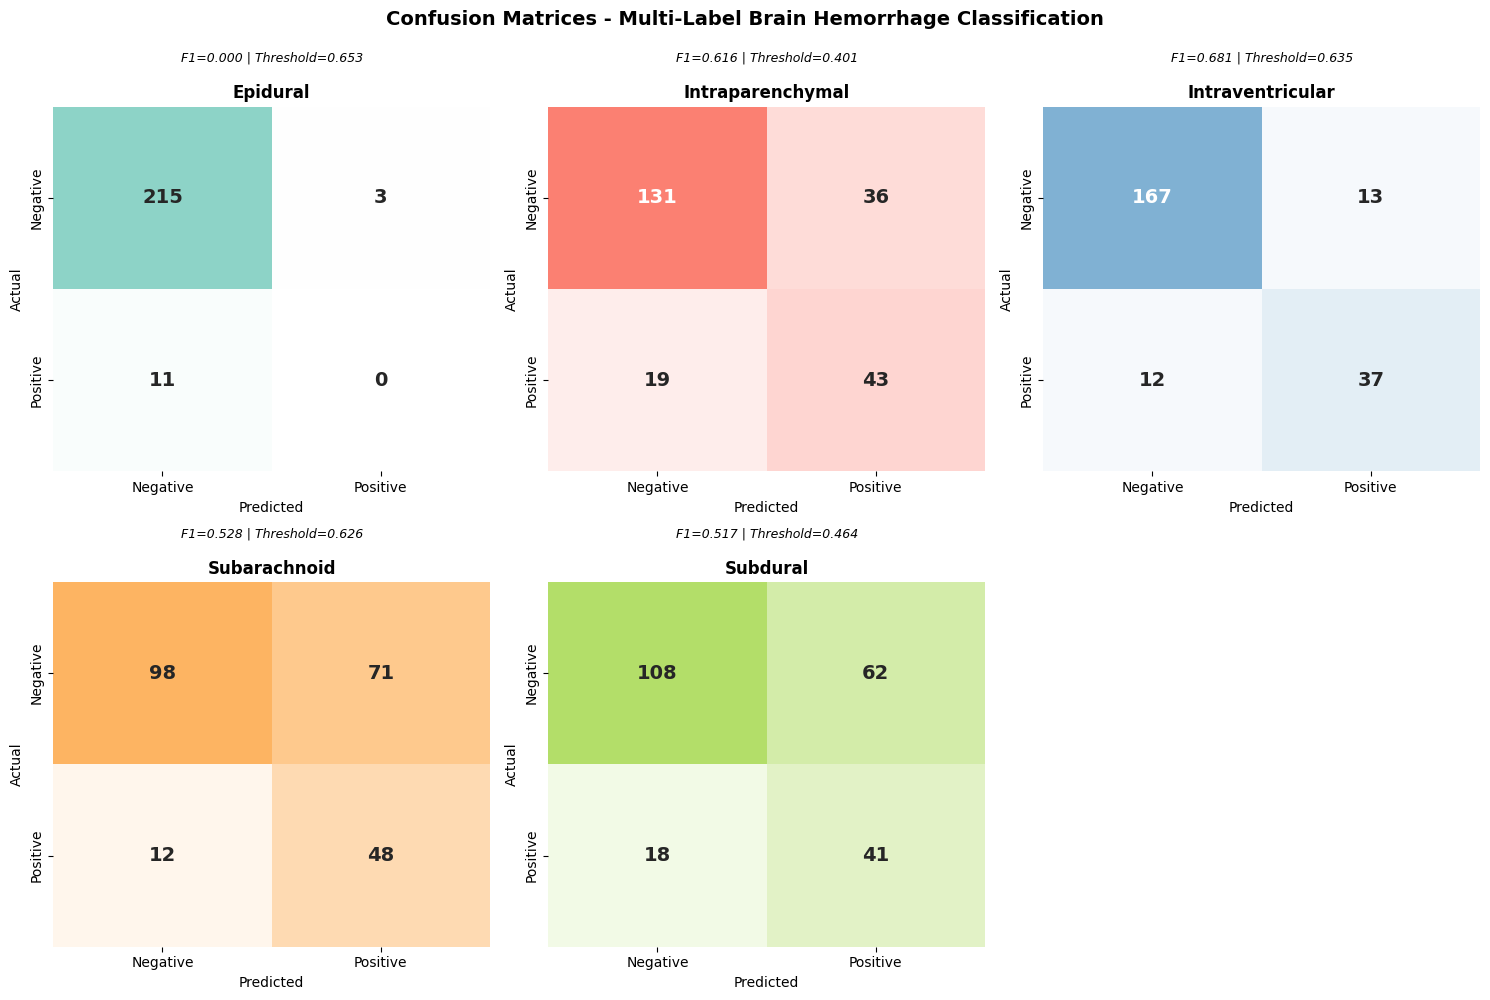

In [18]:
# Plot confusion matrices for each class
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

print("\nGenerating confusion matrices...")

# Get predictions and ground truth
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits)
        
        # Apply optimized thresholds
        preds = torch.zeros_like(probs)
        for i, thr in enumerate(optimal_thresholds):
            preds[:, i] = (probs[:, i] >= thr).float()
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Create figure with confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

class_names_display = ['Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural']
colors = ['#8dd3c7', '#fb8072', '#80b1d3', '#fdb462', '#b3de69']

for i, (name, color) in enumerate(zip(class_names_display, colors)):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    
    # Create custom colormap from white to the class color
    cmap = LinearSegmentedColormap.from_list(f'cmap_{i}', ['white', color])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                ax=axes[i], cbar=False, annot_kws={'size': 14, 'weight': 'bold'},
                vmin=0, vmax=cm.max())
    
    axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=10)
    axes[i].set_ylabel('Actual', fontsize=10)
    axes[i].set_xticklabels(['Negative', 'Positive'])
    axes[i].set_yticklabels(['Negative', 'Positive'])
    
    # Add metrics below title
    tn, fp, fn, tp = cm.ravel()
    thr = optimal_thresholds[i]
    f1 = test_metrics.get(f'f1_{class_names[i]}', 0)
    axes[i].text(0.5, 1.15, f'F1={f1:.3f} | Threshold={thr:.3f}', 
                ha='center', va='top', transform=axes[i].transAxes, 
                fontsize=9, style='italic')

# Hide the 6th subplot
axes[5].axis('off')

plt.suptitle('Confusion Matrices - Multi-Label Brain Hemorrhage Classification', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
cm_path = f'{checkpoint_dir}/confusion_matrices.png'
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
print(f"Saved confusion matrices to: {cm_path}")

plt.show()


Generating performance metrics chart...
Saved to: checkpoints/run_20251019_231624/per_class_metrics.png


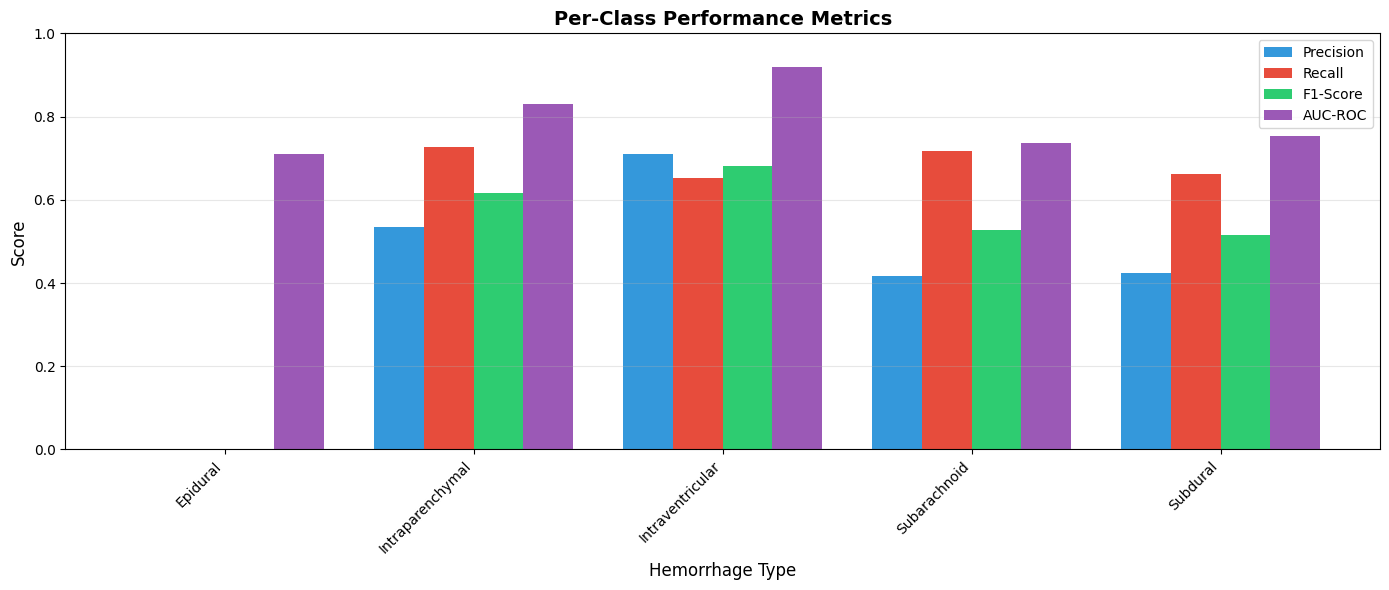

In [19]:
# Create bar chart of per-class metrics
print("\nGenerating performance metrics chart...")

class_names_display = ['Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural']

precisions = [test_metrics[f'precision_{name}'] for name in class_names]
recalls = [test_metrics[f'recall_{name}'] for name in class_names]
f1_scores = [test_metrics[f'f1_{name}'] for name in class_names]
aucs = [test_metrics.get(f'auc_roc_{name}', 0) for name in class_names]

x = np.arange(len(class_names_display))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - 1.5*width, precisions, width, label='Precision', color='#3498db')
ax.bar(x - 0.5*width, recalls, width, label='Recall', color='#e74c3c')
ax.bar(x + 0.5*width, f1_scores, width, label='F1-Score', color='#2ecc71')
ax.bar(x + 1.5*width, aucs, width, label='AUC-ROC', color='#9b59b6')

ax.set_xlabel('Hemorrhage Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_display, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()

metrics_path = f'{checkpoint_dir}/per_class_metrics.png'
plt.savefig(metrics_path, dpi=150, bbox_inches='tight')
print(f"Saved to: {metrics_path}")
plt.show()



Generating ROC curves...
Saved to: checkpoints/run_20251019_231624/roc_curves_all_classes.png


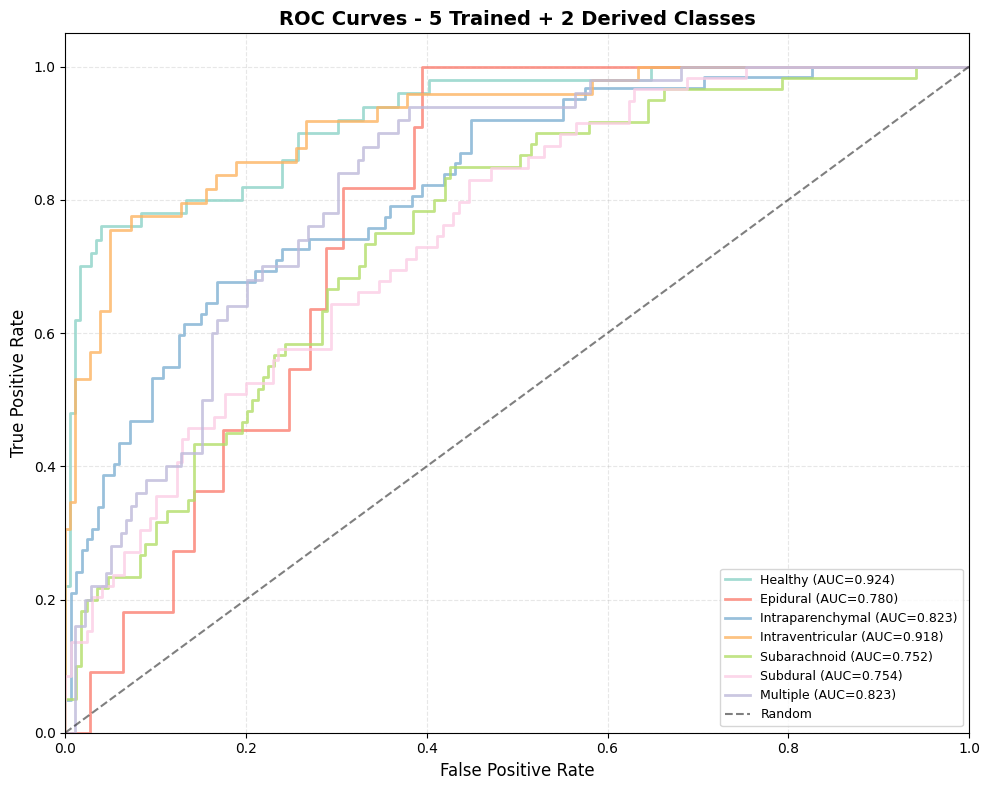

In [20]:
# Plot ROC Curves including derived classes (Healthy and Multiple)
print("\nGenerating ROC curves...")

from sklearn.metrics import roc_curve, auc as compute_auc

# Get probabilities (reuse from confusion matrix cell)
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute derived classes
healthy_targets = (all_targets.sum(axis=1) == 0).astype(int)
multiple_targets = (all_targets.sum(axis=1) > 1).astype(int)

healthy_probs = np.prod(1 - all_probs, axis=1)
prob_none = np.prod(1 - all_probs, axis=1)
prob_exactly_one = sum([all_probs[:, i] * np.prod(1 - np.delete(all_probs, i, axis=1), axis=1) 
                        for i in range(5)])
multiple_probs = 1 - prob_none - prob_exactly_one

# All 7 classes (5 trained + 2 derived)
class_names_roc = ['Healthy', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multiple']
all_targets_list = [healthy_targets] + [all_targets[:, i] for i in range(5)] + [multiple_targets]
all_probs_list = [healthy_probs] + [all_probs[:, i] for i in range(5)] + [multiple_probs]
colors = ['#8dd3c7', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#bebada']

fig, ax = plt.subplots(figsize=(10, 8))

for name, targets, probs, color in zip(class_names_roc, all_targets_list, all_probs_list, colors):
    if len(np.unique(targets)) > 1:
        fpr, tpr, _ = roc_curve(targets, probs)
        roc_auc = compute_auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, alpha=0.8, label=f'{name} (AUC={roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - 5 Trained + 2 Derived Classes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()

roc_path = f'{checkpoint_dir}/roc_curves_all_classes.png'
plt.savefig(roc_path, dpi=150, bbox_inches='tight')
print(f"Saved to: {roc_path}")
plt.show()